In [63]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [64]:
import numpy as np
import pandas as pd

In [65]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [66]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

database_path="...Resources/hawaii.sqlite"

In [67]:
engine = create_engine(f"sqlite:///Resources/hawaii.sqlite")

In [68]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [69]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [70]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [71]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [72]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

# Exploratory Climate Analysis

In [75]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#last data point in the database
last_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first() 
print(last_date)

('2017-08-23',)


In [76]:
# Calculate the date 1 year ago from the last data point in the databas
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)

2016-08-23


In [80]:
# Perform a query to retrieve the data and precipitation scores
prcp=session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prcp_df=pd.DataFrame(prcp,columns=['date','prcp'])
prcp_df.set_index('date').head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


<Figure size 432x360 with 0 Axes>

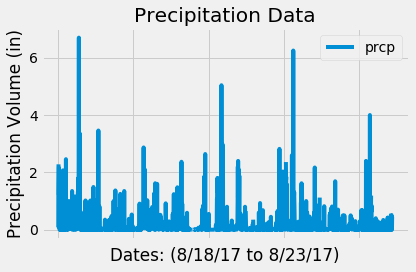

In [88]:
# Use Pandas Plotting with Matplotlib to plot the data
fig1=plt.figure(figsize=(6,5))
prcp_df.plot('date','prcp')
plt.grid(True)
plt.xlabel("Dates: (8/18/17 to 8/23/17)")
plt.ylabel("Precipitation Volume (in)")
plt.title("Precipitation Data")
plt.legend()
plt.tight_layout()
plt.show()
plt.close(fig1)


In [89]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [91]:
#Availabe stations
location_station=session.query(Measurement).group_by(Measurement.station).count()
print("Voila! There's {} stations available... You're welcome!".format(location_station))

Voila! There's 9 stations available... You're welcome!


In [96]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
weather_observations = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
                order_by(func.count(Measurement.tobs).desc()).all()

popular_station=weather_observations[0][0]
popular_station

print("-------------------------------------------------------------------------------------")
print("The HOTTEST station is",popular_station,"and contains",weather_observations[0][1],"weather observations.")
print("-------------------------------------------------------------------------------------")
print("These are the HOTTEST,aka, most active stations, listed in descending order for your convenience!")
for station, count in weather_observations:
    print("Wow, this station id:",station,"has this many weather observations:",count,)
    

-------------------------------------------------------------------------------------
The HOTTEST station is USC00519281 and contains 2772 weather observations.
-------------------------------------------------------------------------------------
These are the HOTTEST,aka, most active stations, listed in descending order for your convenience!
Wow, this station id: USC00519281 has this many weather observations: 2772
Wow, this station id: USC00519397 has this many weather observations: 2724
Wow, this station id: USC00513117 has this many weather observations: 2709
Wow, this station id: USC00519523 has this many weather observations: 2669
Wow, this station id: USC00516128 has this many weather observations: 2612
Wow, this station id: USC00514830 has this many weather observations: 2202
Wow, this station id: USC00511918 has this many weather observations: 1979
Wow, this station id: USC00517948 has this many weather observations: 1372
Wow, this station id: USC00518838 has this many weather

In [101]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temperature_info=session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station==popular_station).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()

session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.station == popular_station).all()

[(54.0, 71.66378066378067, 85.0)]

In [102]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
t_data= session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == popular_station).\
                filter(Measurement.date >= last_year).all()
tobs_df = pd.DataFrame(t_data)
tobs_df.set_index('station', inplace=True)
tobs_df.head()

,tobs
station,
USC00519281,77.0
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0


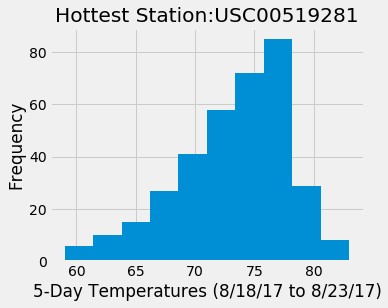

In [105]:
#5-Day Temperature Plot
fig2=plt.figure(figsize=(5,4))
plt.grid(True)
temp_info_df=pd.DataFrame(temperature_info)
plt.hist(temp_info_df['tobs'])
bin_size=12
plt.xlabel("5-Day Temperatures (8/18/17 to 8/23/17)")
plt.ylabel("Frequency")
plt.title("Hottest Station:" + popular_station)
plt.show()

In [106]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()


print(calc_temps('2017-08-18', '2017-08-23'))

[(71.0, 79.31818181818181, 85.0)]


In [112]:
def calc_temps2(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()


print(calc_temps('2016-08-18', '2016-08-23'))
               

[(72.0, 78.13157894736842, 81.0)]


In [115]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
fun_date=dt.date(2017,8,18)
sad_date=dt.date(2017,8,23)
last_year=dt.timedelta(days=365)
tavg_last_year=(calc_temps((fun_date - last_year),(sad_date - last_year)))
print(tavg_last_year)

[(72.0, 78.13157894736842, 81.0)]


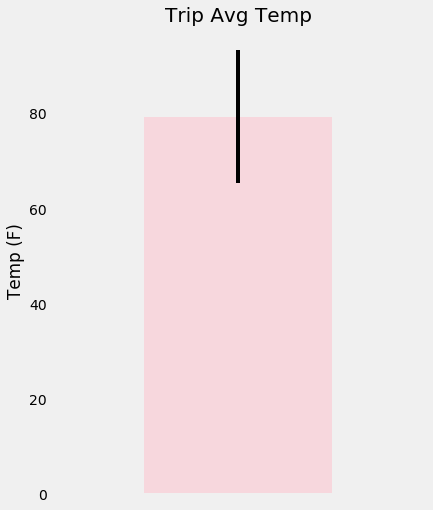

In [122]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_results = calc_temps('2017-08-18', '2017-08-23')
trip_results

trip_df = pd.DataFrame(trip_results, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_df['Avg Temp']
min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='pink')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid()
plt.savefig("TripTempSummary.png")
plt.show()
